# Estimating the correlation length 

* The correlation length $L$ determines whether two points separated by a given distance are correlated or not.
* `DIVAnd` includes several tools to estimate the correlation length.
* We will start with a 2D case and consider the 3D case.
* This notebook can run on multiple CPU threads (see [01-notebooks-basics.ipynb](../1-Intro/01-notebooks-basics.ipynb))

In [1]:
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random
using Printf

# Data reading

The file `WOD-Salinity-Provencal.nc` contains salinity measurement obtained from the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html). for the Provençal Basin (Mediterranean Sea). The profiles were not interpolated vertically.

The resulting correlation length can fluctuate a bit between runs, because the correlation is based on a collection of random pairs. 

## 2D case

* First lets consider only the data on a 2D surface (longitude and latitude)
* Load the data file if it is not already present.

In [2]:
varname = "Salinity"
filename = "../data/WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://dox.ulg.ac.be/index.php/s/PztJfSEnc8Cr3XN/download",filename)
else
    @info("Data file $filename already downloaded")
end


bathname = "../data/gebco_30sec_4.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

lonr = 3.:0.1:11.8
latr = 42.:0.1:44.5
bathisglobal = true
# Extract the bathymetry for plotting
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);




┌ Info: Data file ../data/WOD-Salinity-Provencal.nc already downloaded
└ @ Main In[2]:7
┌ Info: Bathymetry file already downloaded
└ @ Main In[2]:15


Load the data and print basic information about it that can be used for quality check.

In [3]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity")
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (3.0418334007263184, 11.8100004196167)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (-0.0, 2762.0)
              minimum and maximum of obs. dimension 4: (1892-09-25T00:00:00, 2017-10-02T06:14:02.761)
                          minimum and maximum of data: (0.25, 40.0)


It is quite important to remove outliers for the correlation length estimation, as outlires can have a significant impact.

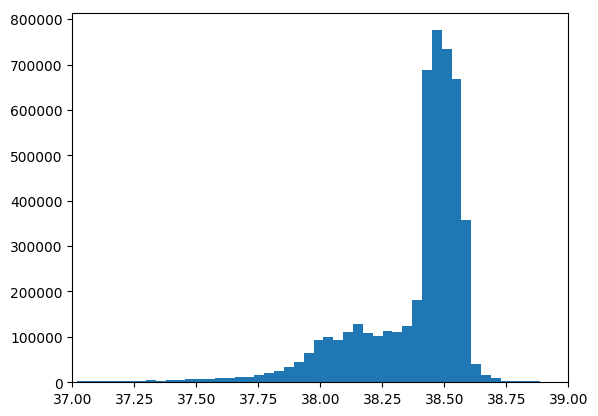

(37, 39)

In [4]:
hist(obsval,1000)
xlim(37,39)

For this example we select only the first month (January) and we remove some questionable data

In [5]:
badid = ["wod_015600782O","wod_015602753O","wod_015604717O","wod_015606732O","wod_015607117O","wod_015607524O","wod_015607893O","wod_015924970O","wod_015926914O","wod_015928739O","wod_016650545O", "wod_008518725O","wod_007643915O","wod_015875365O","wod_006614816O","wod_006614929O","wod_006614937O","wod_007644875O","wod_009996947O","wod_010742471O","wod_010742472O","wod_006614931O","wod_006614934O","wod_006625408O","wod_006752127O","wod_006752129O"]
good = (37.6 .< obsval .< 38.75) .& map(id -> !(id in badid),obsid)


sel = (Dates.month.(obstime) .== 1) .& good
x = (obslon[sel],obslat[sel],obsdepth[sel]);
v = obsval[sel]

z = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000]

#z = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
#    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
#    275, 300, 350, 400, 450, 500, 550, 600];


In [6]:
[0,1,2]

3-element Array{Int64,1}:
 0
 1
 2

Plot the observation at a given level. What do you think will happend if you run `plotobs.(z)`?

In [7]:
function plotobs(z)
    figure()
    sel = (Dates.month.(obstime) .== 1) .& (abs.(obsdepth .- z) .< 50)  .& good # .& (obsval .< 38.3)
    scatter(obslon[sel],obslat[sel],10,obsval[sel], cmap="jet"); colorbar(orientation = "horizontal");
    #print(join(map(s -> '"' * s * '"',String.(unique(obsid[sel]))),","))
    contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
    aspectratio = 1/cos(mean(latr) * pi/180)
    gca().set_aspect(aspectratio)
    title("Depth: $z m")
end

plotobs (generic function with 1 method)

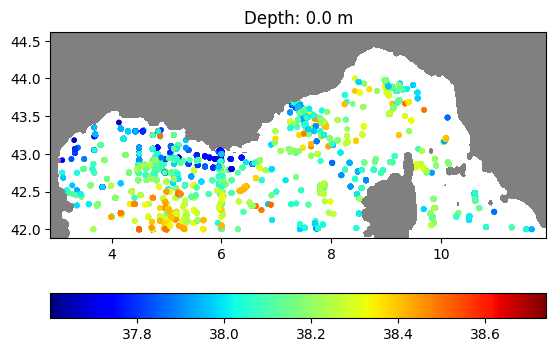

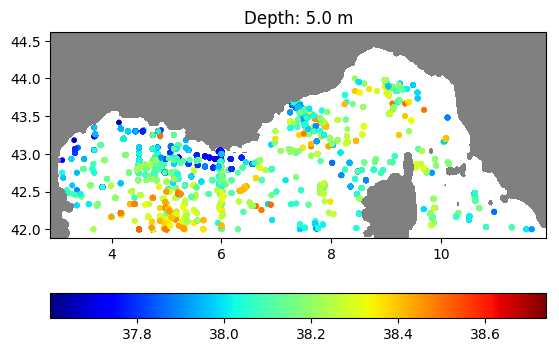

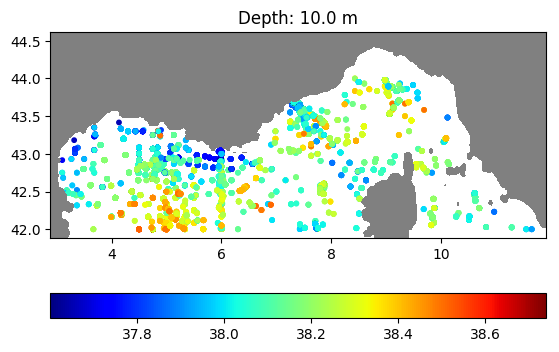

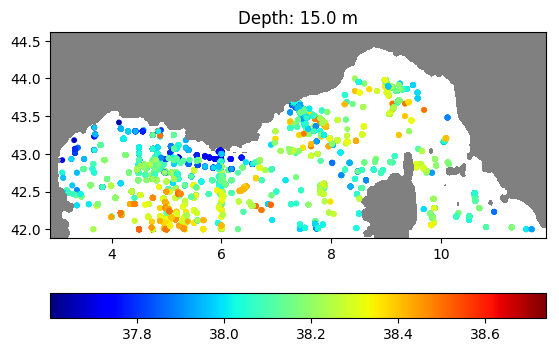

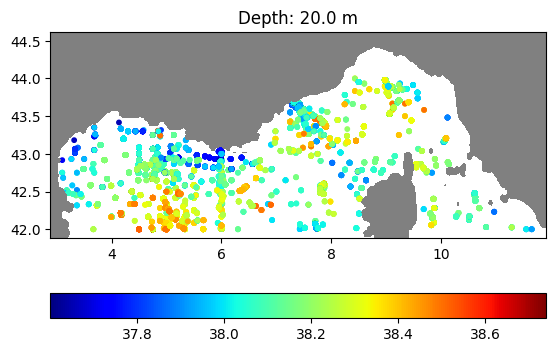

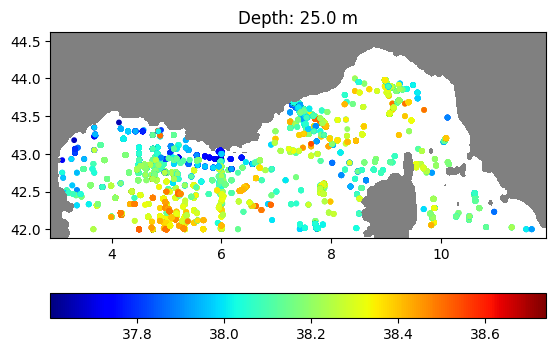

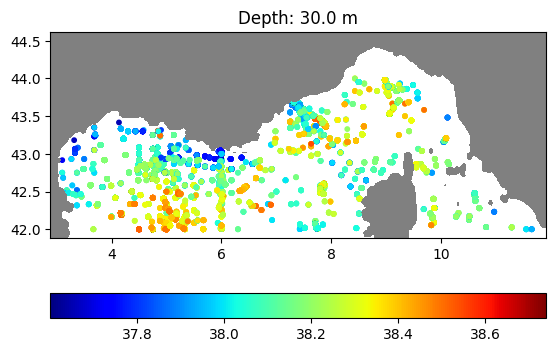

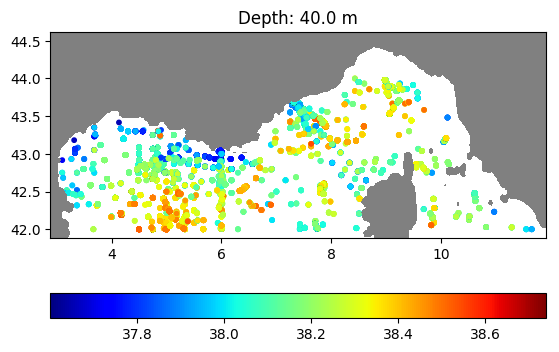

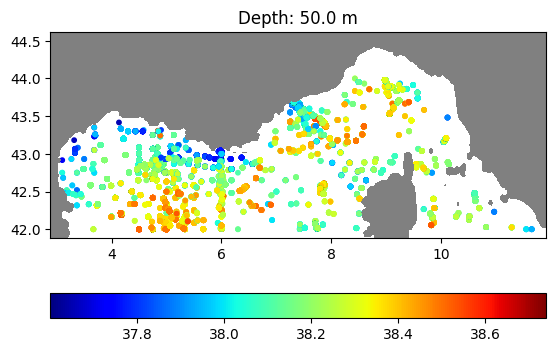

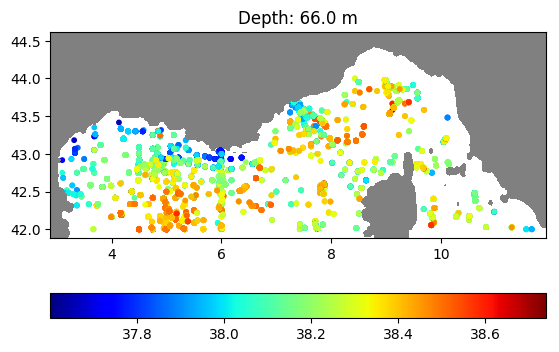

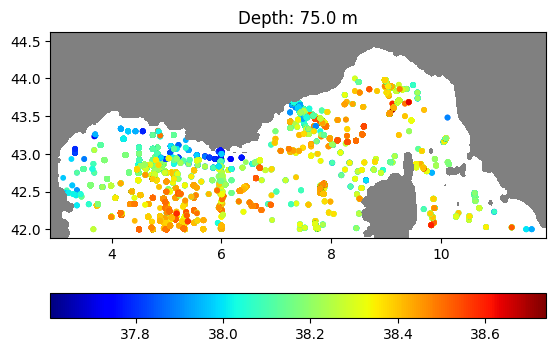

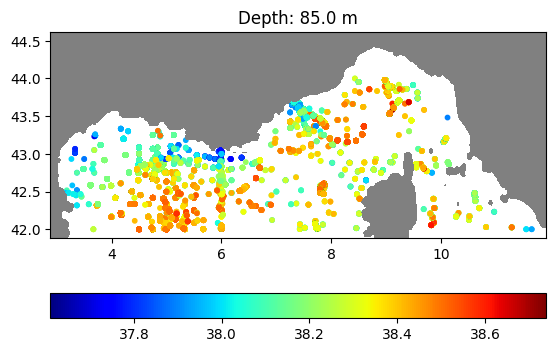

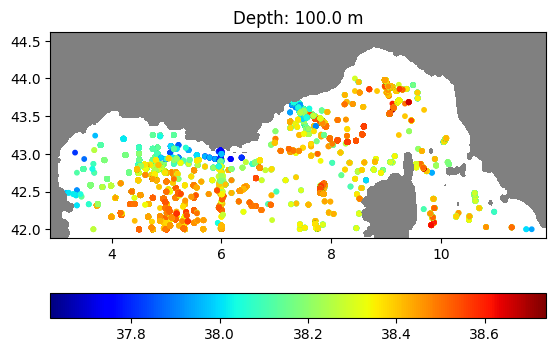

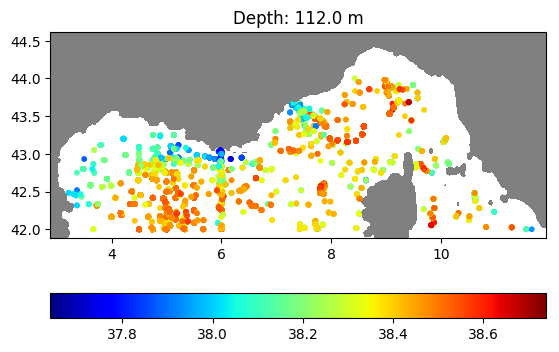

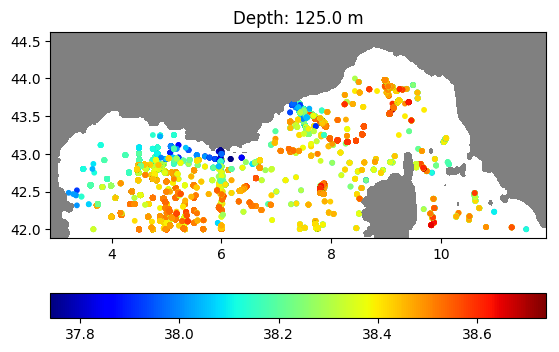

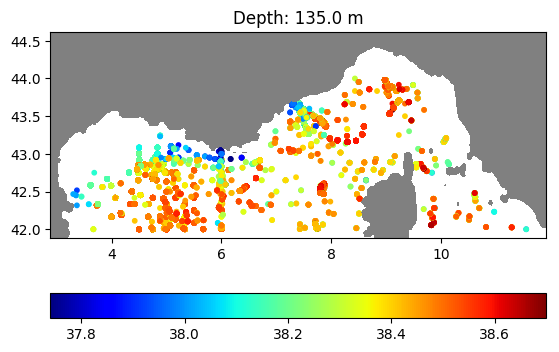

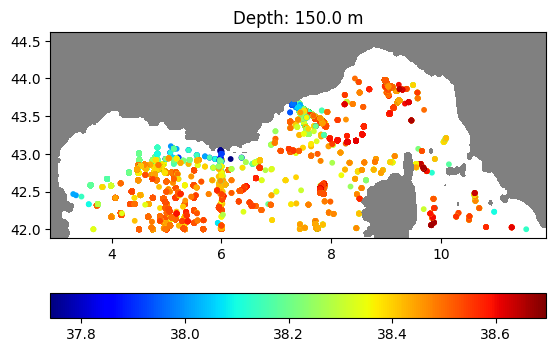

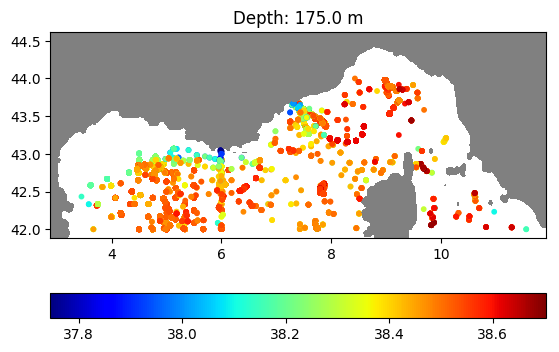

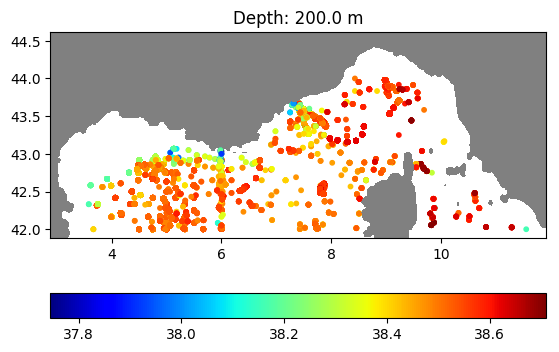

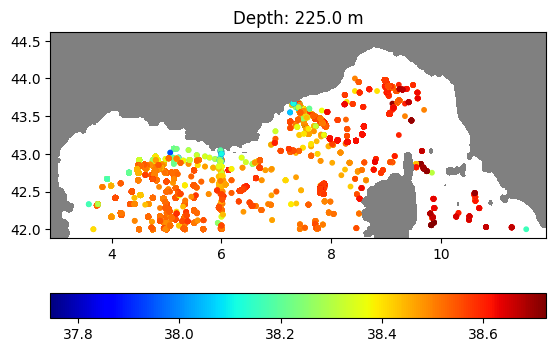

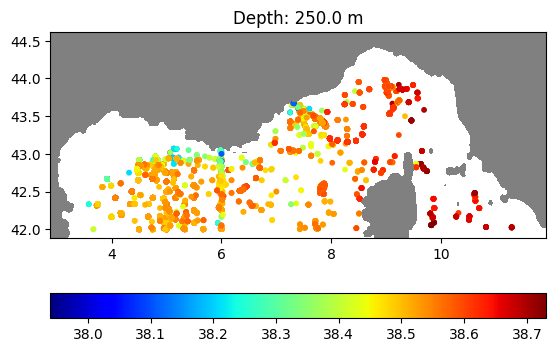

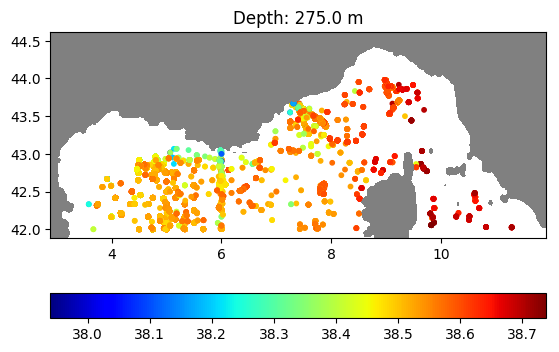

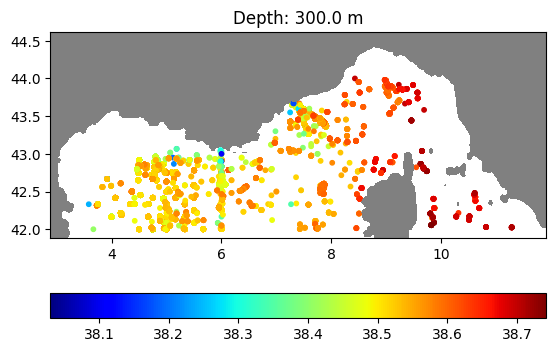

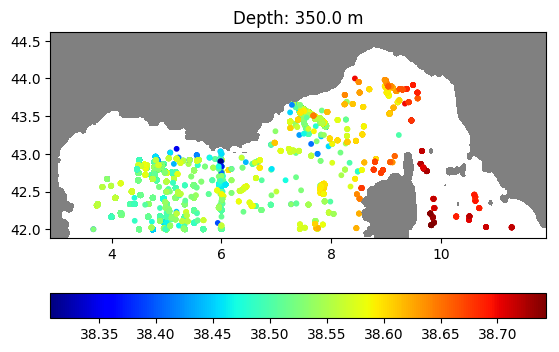

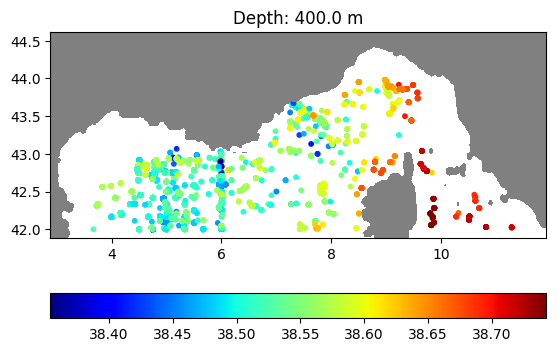

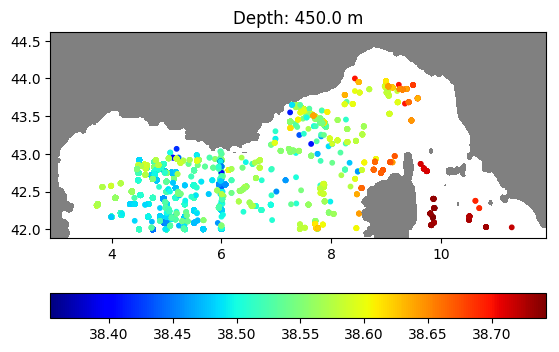

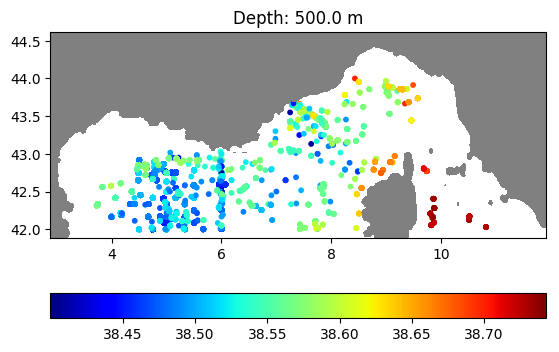

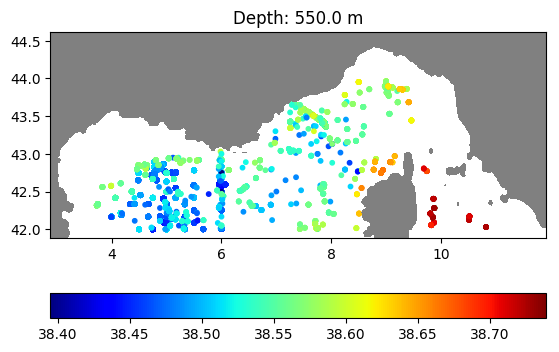

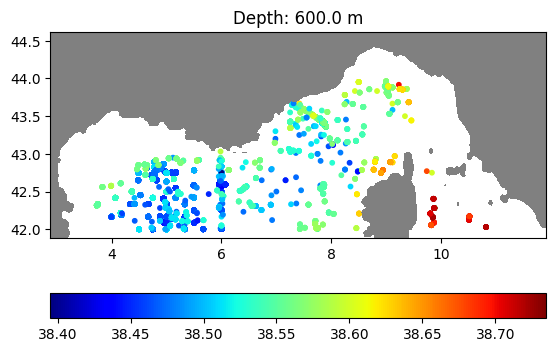

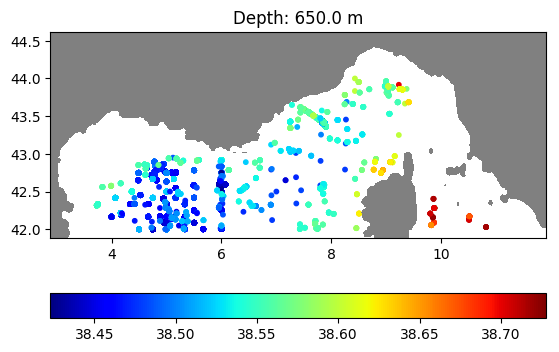

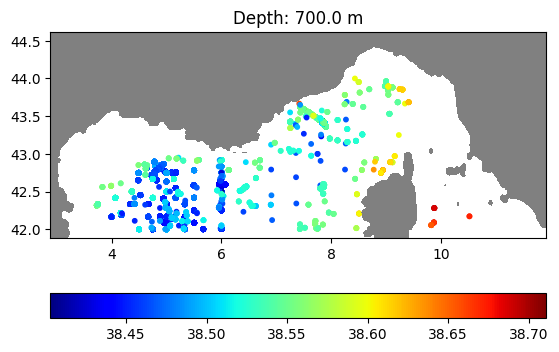

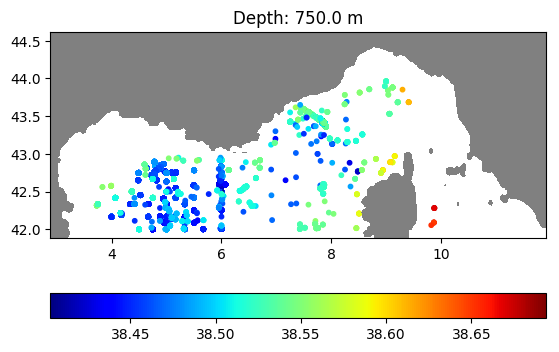

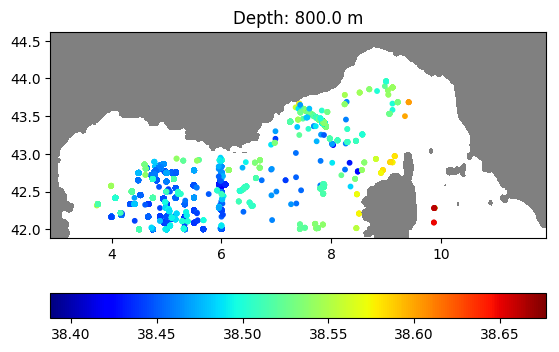

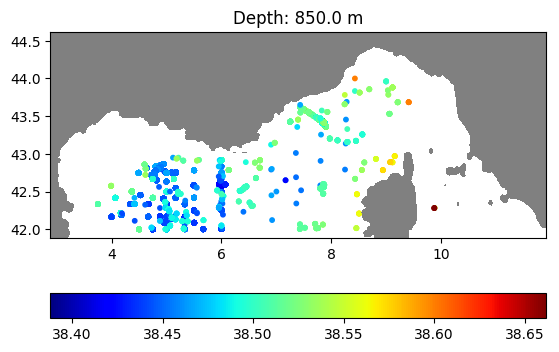

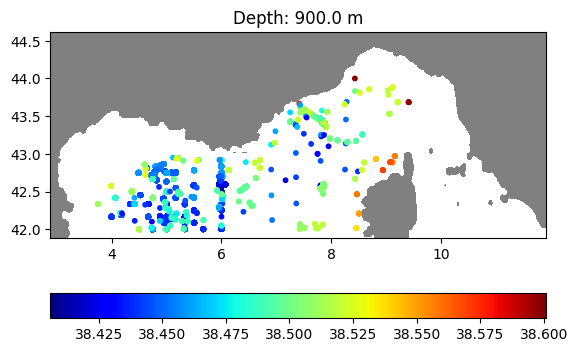

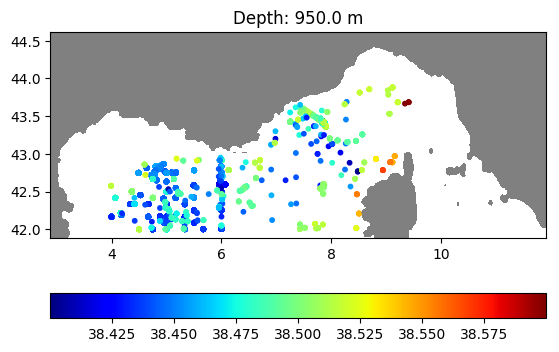

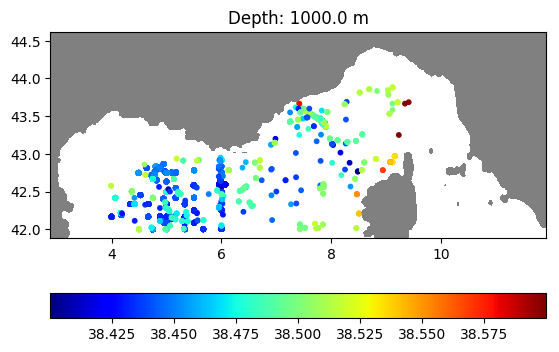

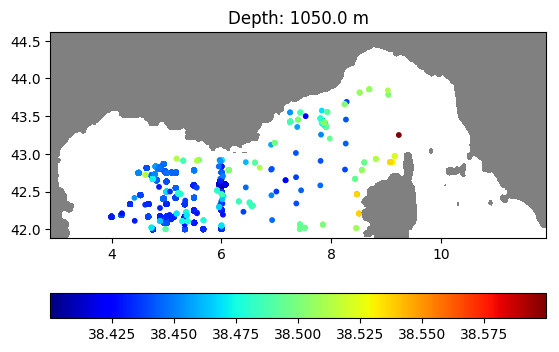

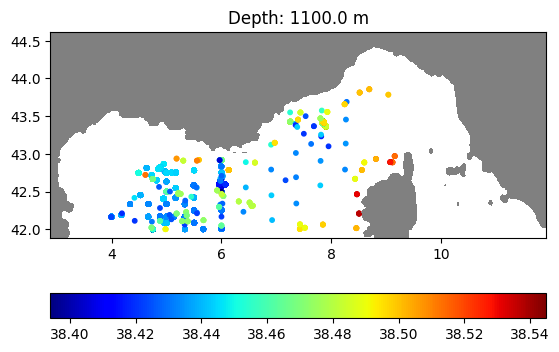

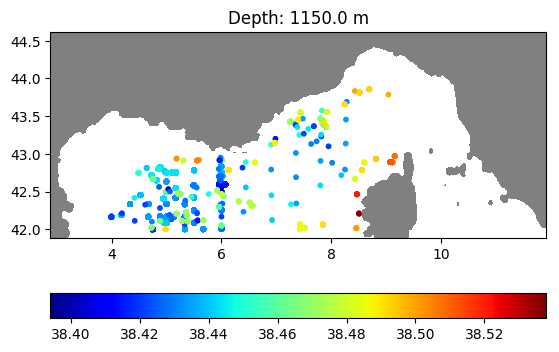

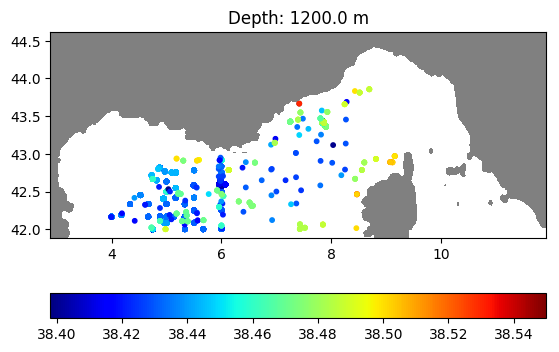

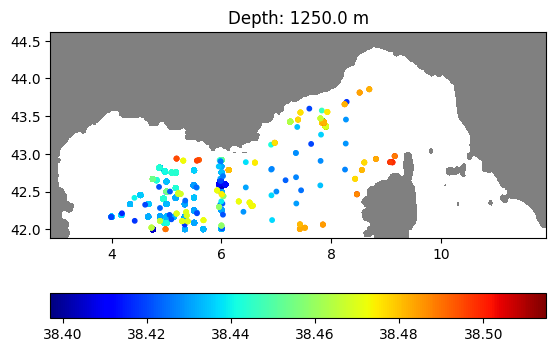

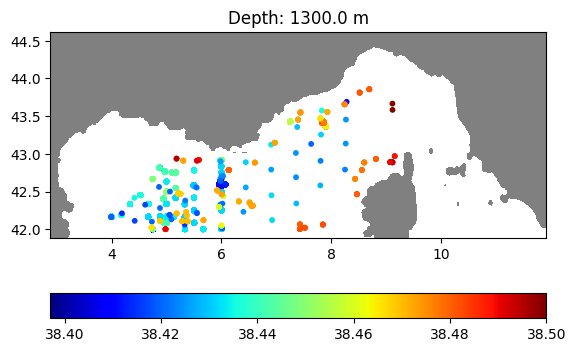

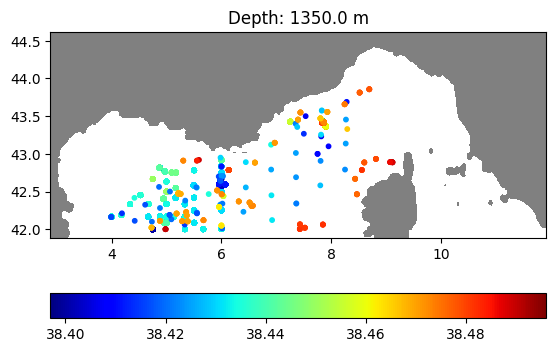

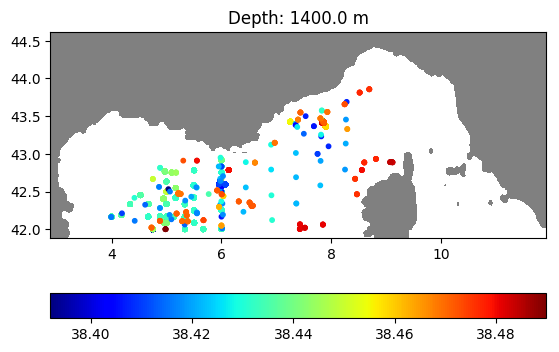

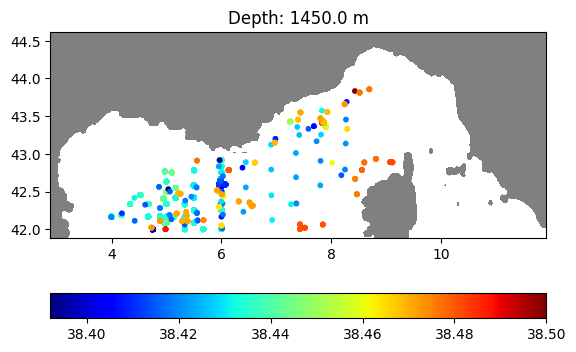

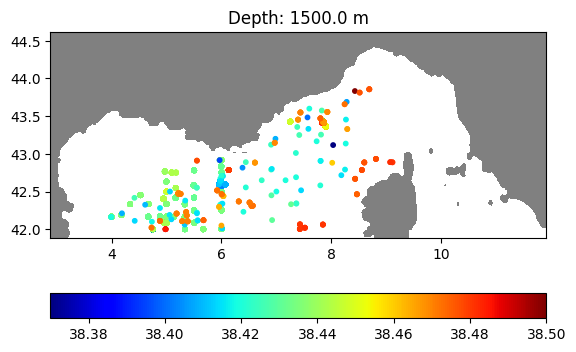

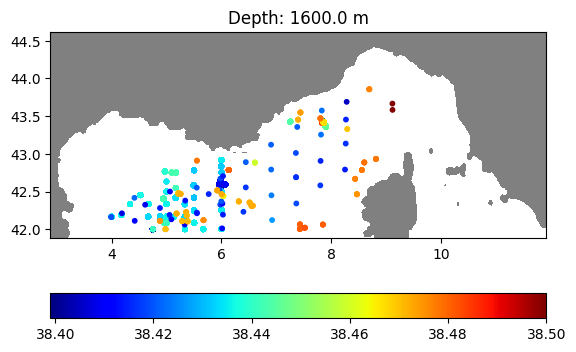

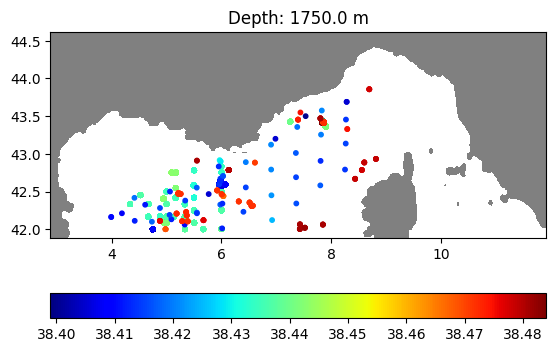

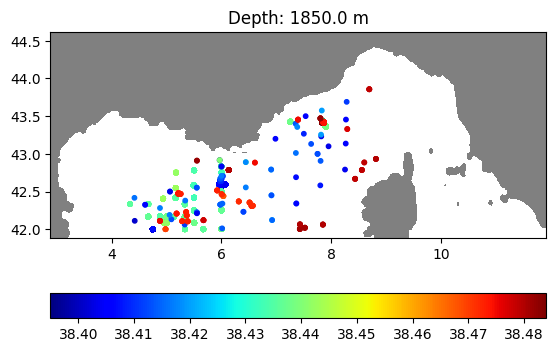

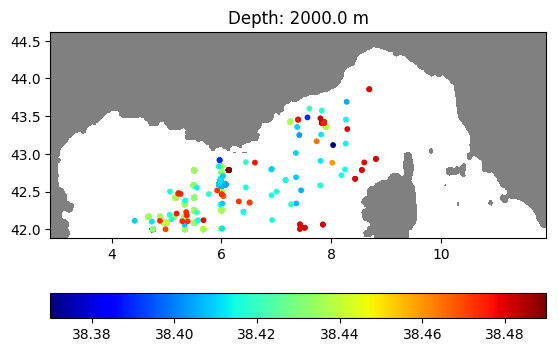

In [8]:
plotobs.(z);

In [9]:
depthr = z

51-element Array{Float64,1}:
    0.0
    5.0
   10.0
   15.0
   20.0
   25.0
   30.0
   40.0
   50.0
   66.0
   75.0
   85.0
  100.0
    ⋮  
 1150.0
 1200.0
 1250.0
 1300.0
 1350.0
 1400.0
 1450.0
 1500.0
 1600.0
 1750.0
 1850.0
 2000.0

In [10]:
mask, pmn, xyi = DIVAnd.domain(bathname, bathisglobal, lonr, latr, depthr)
sz = size(mask);
# obs. coordinate matching selection
xsel = (obslon[sel],obslat[sel],obsdepth[sel])

vm = mean(obsval[sel])
va = obsval[sel] .- vm
toaverage = [true, true, false]
background_len = (zeros(sz),zeros(sz),fill(50.,sz))
background_epsilon2 = 1000.


                    fi, vaa = DIVAnd.DIVAnd_averaged_bg(
                        mask,
                        pmn,
                        xyi,
                        xsel,
                        va,
                        background_len,
                        background_epsilon2,
                        toaverage;
                    )

                    fbackground = fi .+ vm
                    @debug "fbackground: $(fbackground[1,1,:])"

v = vaa;
sel2 = isfinite.(v)
x = (xsel[1][sel2],xsel[2][sel2],xsel[3][sel2])
v = v[sel2];

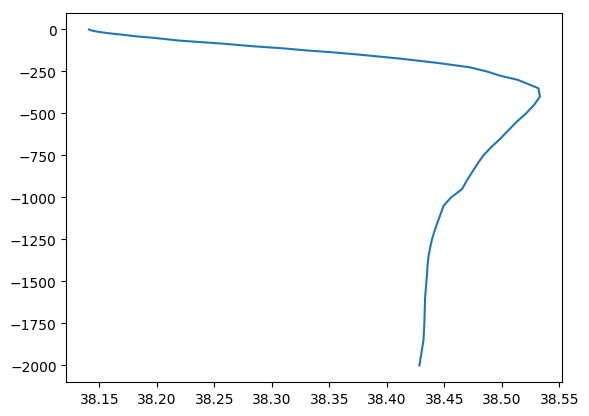

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f84bc2a9a58>

In [11]:
plot(fbackground[1,1,:],-depthr)

### Horizontal correlation length
Estimate the horizontal correlation length for different depth levels    
(can take a few minutes).

In [12]:
?fithorzlen

search: fithorzlen



```
lenxy,dbinfo = DIVAnd.fithorzlen(x,value,z)
```

Determines the horizontal correlation length `lenxy` based on the measurments `value` at the location `x` (tuple of 3 vectors corresponding to longitude, latitude and depth) at the depth levels defined in `z`.

Optional arguments:

  * `smoothz` (default 100): spatial filter for the correlation scale
  * `searchz` (default 50): vertical search distance (can also be a function of the depth)
  * `maxnsamp` (default 5000): maximum number of samples
  * `limitlen` (default false): limit correlation length by mean distance between  observations
  * `limitfun` (default no function): a function with with the two arguments (depth and

estimated correlation length) which returns an adjusted correlation length. For example to force the correlation length to be between 300 km and 50 km one would use the following: `limitfun = (z,len) -> max(min(len,300_000),10_000))`. If provided `limitfun` is used before and after the smoothing.

  * `epsilon2` (default is a vector of the same size as `value` with all elements  equal to 1): the relative error variance of the observations. Less reliable  observation would have a larger corresponding value.
  * `distfun`: function computing the distance between the points `xi` and `xj`.

Per default it represent the Euclidian distance.


In [13]:
@time lenxy,infoxy = fithorzlen(x,v,z; distfun = DIVAnd.distfun_m, searchz = z -> (z/4+10));

┌ Info: Data points at z=0.0: 3365, horz. correlation length: 16666.258916439838 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=5.0: 5739, horz. correlation length: 16764.154402248707 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=10.0: 8072, horz. correlation length: 15948.74396667759 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=15.0: 9573, horz. correlation length: 17122.35701579459 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=20.0: 10929, horz. correlation length: 17647.18150405224 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=25.0: 11921, horz. correlation length: 17482.537055840763 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=30.0: 12284,

┌ Info: Data points at z=1850.0: 27828, horz. correlation length: 13910.545327460632 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Warning: Too few data. Will use guesses (np = 8, RLz = 13901.612194260466, )
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:895
┌ Info: Data points at z=2000.0: 22368, horz. correlation length: 13901.612194260466 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Smoothed horz. correlation length at z=0.0: 14497.16240243883
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=5.0: 14490.975070461236
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=10.0: 14478.673775135607
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=15.0: 14460.40566348577
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/s

284.809960 seconds (2.53 G allocations: 75.621 GiB, 4.79% gc time)


Information about the fitting:


In [14]:
lenxy

51-element Array{Float64,1}:
  14497.16240243883  
  14490.975070461236 
  14478.673775135607 
  14460.40566348577  
  14436.392482336143 
  14406.93181495795  
  14372.398737965315 
  14289.474616997366 
  14192.702428401224 
  14021.610281908357 
  13931.076030747214 
  13844.115539331771 
  13763.474458021416 
      ⋮              
 104263.8868630293   
  59123.75193818162  
  19681.34271859361  
   7314.360741188398 
   4709.273817158907 
   4188.435965816161 
   4088.2580236583676
   4079.9772631394853
   4107.767933187897 
   4126.939413530886 
   4139.9807158420945
   4150.231822256635 

In [15]:
infoxy[:fitinfos][1]

Dict{Symbol,Any} with 8 entries:
  :sn          => 0.581255
  :rqual       => 0.90341
  :fitcovar    => [NaN, 0.0106624, 0.0101699, 0.00956712, 0.00891498, 0.0082489…
  :meandist    => 1.74699e5
  :covar       => [0.0145506, 0.012179, 0.00962637, 0.00823227, 0.00762851, 0.0…
  :range       => 2:23
  :distx       => 0.0:2183.7341347536476:705346.1255254282
  :covarweight => [3.31043e13, 3.3094e13, 3.33182e13, 3.31471e13, 3.30989e13, 3…

Extract the information for the level `k = 1`:
* `covar`: the empirical covariance
* `fitcovar`: the fitted empirical covariance
* `distx`: distance
* `range`: part of `covar` used for the fitting
* `rqual`: the quality for the fit (1: excellent, 0: poor)

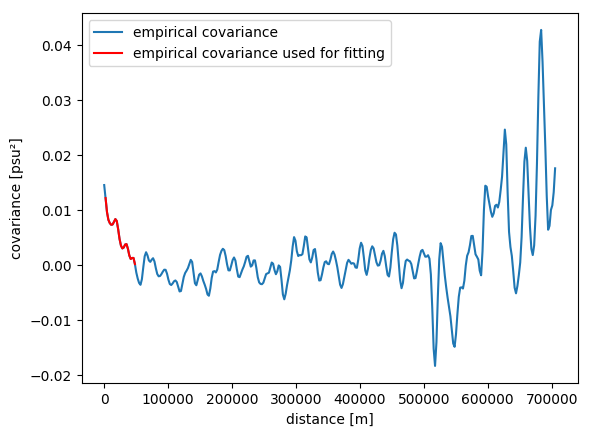

In [16]:
k = 1
covar = infoxy[:fitinfos][k][:covar]
fitcovar = infoxy[:fitinfos][k][:fitcovar]
distx = infoxy[:fitinfos][k][:distx]
range = infoxy[:fitinfos][k][:range]
rqual = infoxy[:fitinfos][k][:rqual]

plot(distx,covar,label="empirical covariance")
plot(distx[range],covar[range],"r",label="empirical covariance used for fitting")
ylabel("covariance [psu²]")
xlabel("distance [m]")
legend();

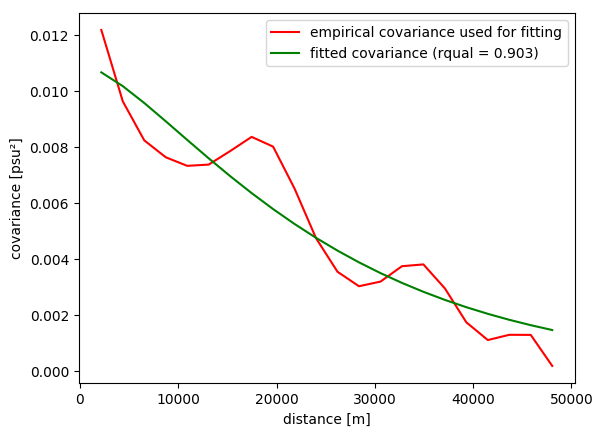

In [17]:
plot(distx[range],covar[range],"r",label="empirical covariance used for fitting")
plot(distx[range],fitcovar[range],"g",label="fitted covariance (rqual = $(@sprintf("%4.3f",rqual)))")
ylabel("covariance [psu²]")
xlabel("distance [m]")
legend();

🖋️ Try different values of k (the level index) and re-run the previous two cells.     
Note that at some level the fit was quite poor. Additional filtering (vertically) is done to smooth the horizontal correlation length.

Make a plot of the horizontal correlation length with respect to the depth. 

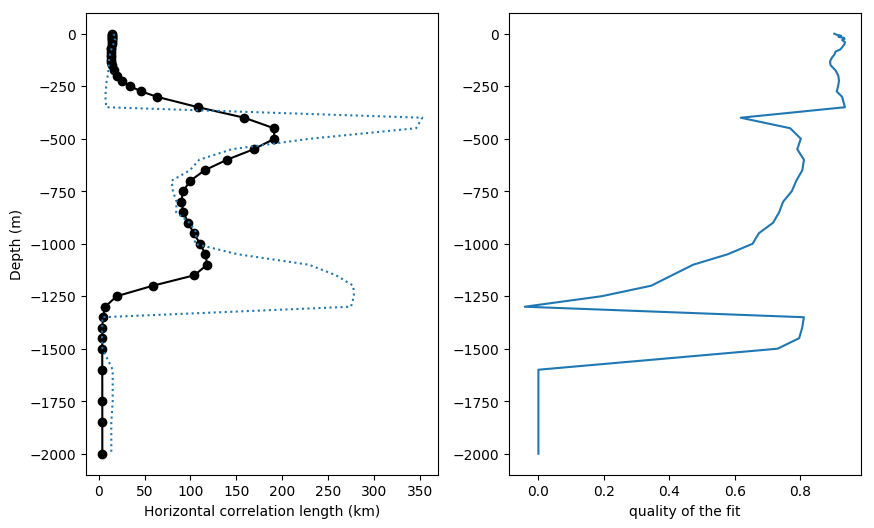

In [18]:
rqual = [f[:rqual] for f in infoxy[:fitinfos]]
figure(figsize = (10,6))
subplot(1,2,1)
plot(lenxy/1000,-z, "ko-")
plot(infoxy[:len]/1000,-z,":");
xlabel("Horizontal correlation length (km)")
ylabel("Depth (m)")
#xlim(0,180)
subplot(1,2,2)
plot(rqual,-z)
xlabel("quality of the fit");

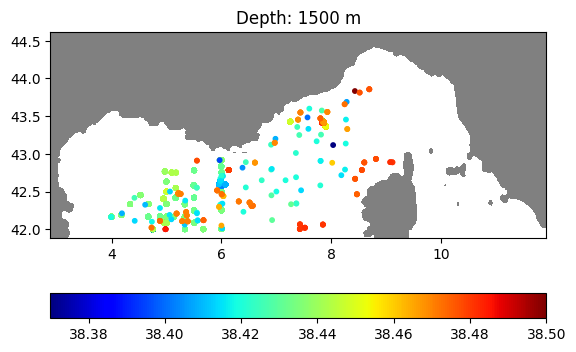

In [19]:
plotobs(1500);

It is useful to limit the acceptable range of the correlation length by providing a function `limitfun` with the argument depth `z` and estimated correlation length `len`. It the returns the adjusted correlation length. This adjustememt is done before the filtering.

In [20]:
@time lenxy2,infoxy2 = fithorzlen(x,v,z; distfun = DIVAnd.distfun_m, limitfun = (z,len) -> min(max(len,25e3),60e3));


┌ Info: Data points at z=0.0: 17698, horz. correlation length: 16749.458866678164 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=5.0: 19460, horz. correlation length: 16769.60767656895 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=10.0: 21024, horz. correlation length: 16671.4921126545 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=15.0: 22717, horz. correlation length: 16911.155642505877 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=20.0: 24290, horz. correlation length: 16582.095427290795 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=25.0: 26100, horz. correlation length: 16602.324694864627 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=30.0: 27

┌ Info: Data points at z=1850.0: 4012, horz. correlation length: 13957.960520523642 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Warning: Too few data. Will use guesses (np = 8, RLz = 13879.356866879221, )
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:895


264.620971 seconds (2.47 G allocations: 73.582 GiB, 5.00% gc time)


┌ Info: Data points at z=2000.0: 1823, horz. correlation length: 13879.356866879221 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Smoothed horz. correlation length at z=0.0: 25005.842745467486
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=5.0: 25006.036544330076
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=10.0: 25006.428954159008
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=15.0: 25007.02967274504
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=20.0: 25007.853430947827
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=25.0: 25008.920214300117
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed h

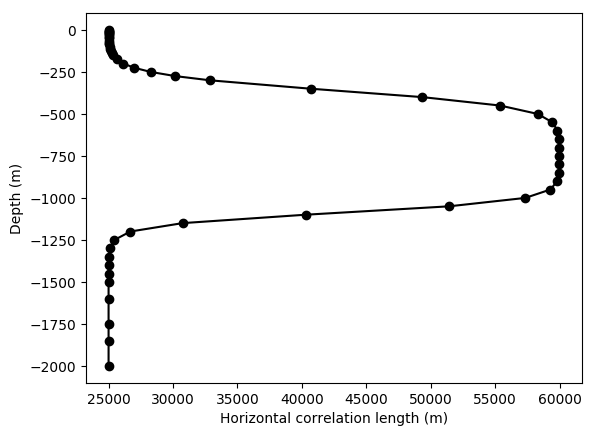

In [21]:
plot(lenxy2,-z, "ko-")
#plot(infoxy2[:len],-z,":");
xlabel("Horizontal correlation length (m)")
ylabel("Depth (m)");

### Vertical correlation length 
The vertical correlation length is also estimated for different depth levels

In [22]:
?fitvertlen

search: fitvertlen



```
lenz,dbinfo = DIVAnd.fitvertlen(x,value,z,...)
```

See also DIVAnd.fithorzlen


In [23]:
mean(v)

0.0015955342300290856

In [24]:
lenz,infoz = fitvertlen(x,v,z);

┌ Info: Vert. correlation length at z=0.0: 111.00469122104646
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=5.0: 107.05598400000001
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=10.0: 112.05472825561526
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=15.0: 115.73071791311645
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=20.0: 97.8453338873291
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=25.0: 73.35839999999999
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=30.0: 98.08367905004884
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=40.0: 97.67486399999999
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl

Make a plot

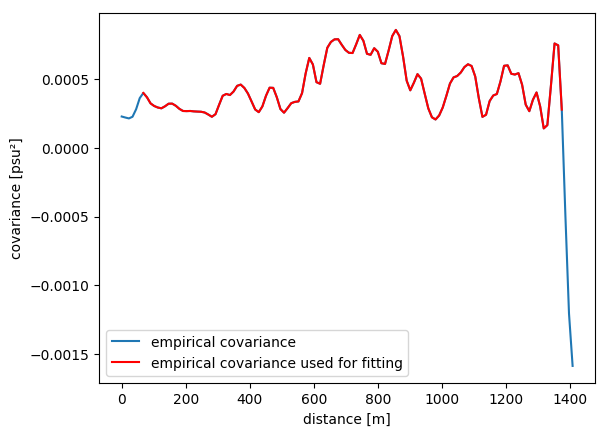

In [25]:
k = 45
covar = infoz[:fitinfos][k][:covar]
fitcovar = infoz[:fitinfos][k][:fitcovar]
distx = infoz[:fitinfos][k][:distx]
range = infoz[:fitinfos][k][:range]
rqual = infoz[:fitinfos][k][:rqual]

plot(distx,covar,label="empirical covariance")
plot(distx[range],covar[range],"r",label="empirical covariance used for fitting")
ylabel("covariance [psu²]")
xlabel("distance [m]")
legend();

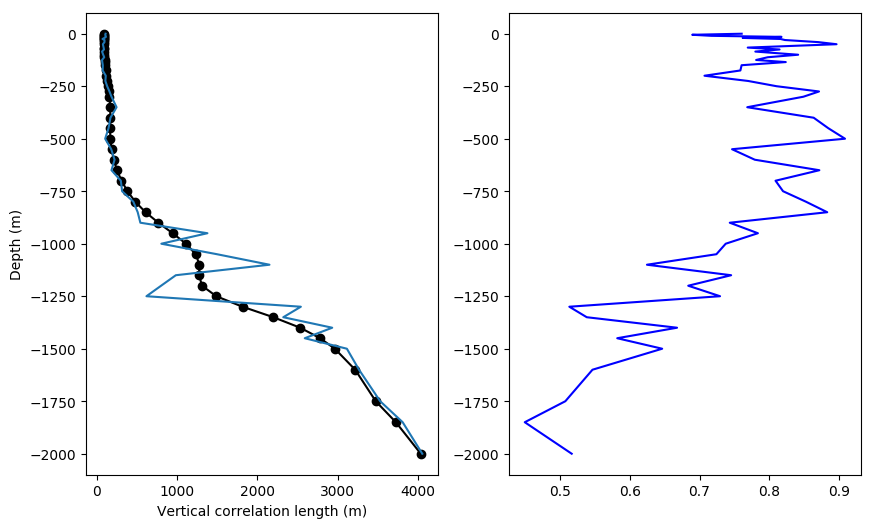

In [26]:
rqual = [f[:rqual] for f in infoz[:fitinfos]]
figure(figsize = (10,6))
subplot(1,2,1)
plot(lenz,-z, "ko-")
plot(infoz[:len],-z, "-")
xlabel("Vertical correlation length (m)")
ylabel("Depth (m)");

subplot(1,2,2)
plot(rqual,-z, "b-");

In [27]:
infoz[:fitinfos][end]

Dict{Symbol,Any} with 8 entries:
  :sn          => 0.0455525
  :rqual       => 0.516969
  :fitcovar    => [NaN, 0.000358833, 0.000358789, 0.000358723, 0.000358638, 0.0…
  :meandist    => 1046.02
  :covar       => [0.000214772, 0.000209243, 0.000237038, 0.000301121, 0.000365…
  :range       => 7:120
  :distx       => 0.0:15.955835689544678:1994.4794611930847
  :covarweight => [2.55467e15, 2.55683e15, 8.99571e15, 1.77811e15, 1.76983e15, …

An alternative is to use of the vertical coordinate to obtain a reasonable guess of the vertical correlation

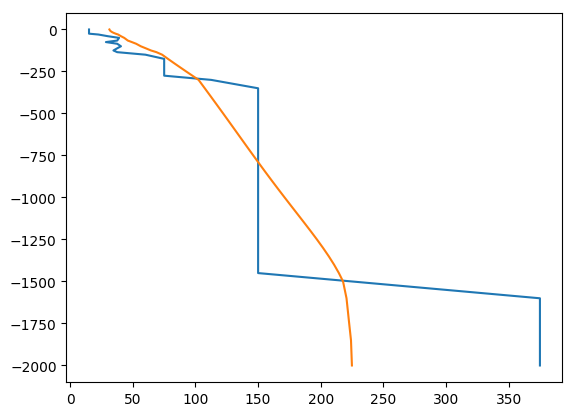

In [28]:
Dz = (z[3:end] - z[1:end-2])/2
lenz = 3 * [Dz[1], Dz..., Dz[end]]
lenzf = DIVAnd.smoothfilter(1:length(lenz),lenz,10)
plot(lenz,-z)
plot(lenzf,-z);